#  Extraindo comentários do Instagram

<p>Este projeto começou com um post em um grupo de Facebook onde costumo ajudar e interagir:</p>

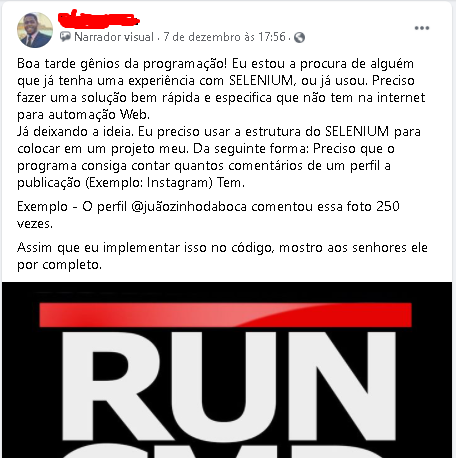

<p>Como eu estava no fim do dia, finalizando a meta de estudos decidi brincar um pouco e tentar fazer essa solução por mim mesmo, e acho que cheguei em um resultado bom, pois ninguém mais respondeu o post....</p>

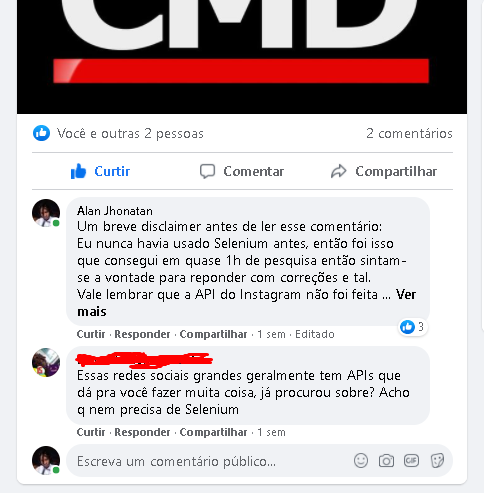

<p>E aqui vou mostrar a minha solução que deixei no grupo:</p>

#### Importação de algumas libs

In [1]:
import time                                     #to use time.sleep()
from seleniumwire import webdriver              # using seleniumwire to allow inspect network requests/responses 
from seleniumwire.webdriver import ActionChains # using ActionChains to trigger .click() event on any kind of element

In [2]:
import json
from requests import Request, Session

In [3]:
import pandas as pd

In [4]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [5]:
import matplotlib.pyplot as plt

### Aqui é onde você define qual o post você vai usar

Eu usei como referência os posts:
- [***Alanzoka (Foto na E3)***](https://www.instagram.com/p/BkBUPYyl2-2/)
- [***Duncan Trussel (Sobre o lançamento da série Midnight Gospel)***](https://www.instagram.com/p/B-pln9YJ_6z/)
- [***Bolsonaro (Auxílio Emergencial)***](https://www.instagram.com/p/CIc3JKOBVRZ/)
- [***Bolsonaro (Live com Ministros)***](https://www.instagram.com/p/CGYbktFBr1S/)

#### Troque o 'post_url' para usar algum post que você queira

In [6]:
post_url = 'https://www.instagram.com/p/BkBUPYyl2-2/'

post_url

'https://www.instagram.com/p/BkBUPYyl2-2/'

#### Declaração de algumas funções

In [7]:
def queryExtractor(url):
    return url[url.find('after%22%3A%22') + len('after%22%3A%22') : url.find('%3D%3D%22%7D')]

def urlfier (arr):
    return str(''.join(arr))

urlfier(['Its ', 'working ', 'perfectly ', '!'])

'Its working perfectly !'

#### Declaração de algumas variáveis importantes

In [8]:
query_hash = 'https://www.instagram.com/graphql/query/?query_hash='
post_hash = post_url[28:len(post_url) - 1]
matches = [post_hash, query_hash, 'shortcode', 'first', 'after']
total_comments = 0


post_hash, query_hash, total_comments

('BkBUPYyl2-2', 'https://www.instagram.com/graphql/query/?query_hash=', 0)

### Usando Selenium com ChromeDriver

##### (Optei por usar o Selenium, pois é necessário causar o click em um botão para carregar mais comentários)

<p> Qualquer problema com a versão do chrome driver basta trocar na variável <strong><i>chrome_version</i></strong></p>

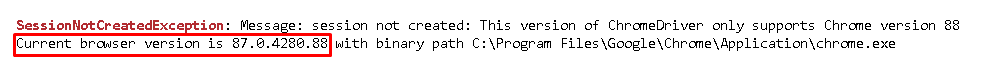

<p> As versões que disponibilizei são: <strong>'88', '87', '86'</strong>.</p>
<p> Caso não encontre a sua basta acessar a <a href="https://chromedriver.chromium.org/downloads">área de Downloads do ChromeDriver</a> e baixar a sua versão na pasta <strong>/chrome<strong> deste projeto.</p>

In [9]:
chrome_version = '87' # string

directory = './chrome/chromedriver_' #path to .exe

#### Aqui eu faço ele abrir o navegador no post

<p><i>Recomendo que espere até o navegador abrir no post e parar de carregar para proceder</i></p>

In [10]:
#using ChromeDriver
print('Espere o browser o post...')

driver = webdriver.Chrome(directory + chrome_version + '.exe') # Aqui é onde ele acessa o ChromeDriver.
driver.get(post_url)

print('Pronto ! Pode continuar...')

Espere o browser o post...
Pronto ! Pode continuar...




<p> Eu uso o <strong>click no botão de (+)</strong> para ele fazer a requisição de mais comentários, assim eu posso rastrear a endpoint para automatizar as próximas requisições.</p>

<p>Seleciono o botão pela classe dele que é:</p>
<p><strong><i>'glyphsSpriteCircle_add__outline__24__grey_9 u-__7'</i><strong></p>

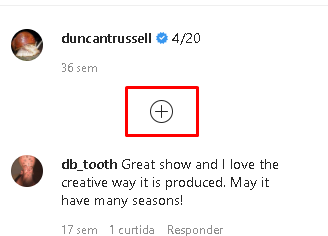

#### Capturo o botão

In [11]:
element = driver.find_element_by_class_name('glyphsSpriteCircle_add__outline__24__grey_9.u-__7')

element

<selenium.webdriver.remote.webelement.WebElement (session="67607b87c419340c56a1479f435fc3cb", element="ca60bb58-f202-403f-8bc4-c9c93d6090e9")>

#### Realizo o evento de <i>click</i> no botão

In [12]:
# trigger the button to make next page request
element.click()

#### Busco a requisição que é referente aos comentários

In [13]:
#handle the url of Instagram GraphQL comments endpoint 
request_url = ''

#search the endpoint url
for request in driver.requests:
    if all(x in request.url for x in matches):
        request_url = request.url

request_url

'https://www.instagram.com/graphql/query/?query_hash=bc3296d1ce80a24b1b6e40b1e72903f5&variables=%7B%22shortcode%22%3A%22BkBUPYyl2-2%22%2C%22first%22%3A13%2C%22after%22%3A%22QVFEMndBNFNEcmxCc3liM05sb2NzOGk5NUFsQmRuTFllMDNKOXhCSWM2ZmRjQnVrQ252VXhiMWRxclpRYXZEMXptV0NBU25yQWdlcHB2QVNUNnlsNHVsYg%3D%3D%22%7D'

In [14]:
#handle all hash of all pages
pages_hash = []
pages_hash.append(queryExtractor(request_url))

pages_hash

['QVFEMndBNFNEcmxCc3liM05sb2NzOGk5NUFsQmRuTFllMDNKOXhCSWM2ZmRjQnVrQ252VXhiMWRxclpRYXZEMXptV0NBU25yQWdlcHB2QVNUNnlsNHVsYg']

#### Preparo uma request com header personalizada para a API do instagram não me derrubar após 2 requests... que aconteceu várias e várias vezes 
### :(

In [21]:
#Settin Up the custom request infos

headers = {
    "accept": "*/*",
    "authority": "www.instagram.com",
    "scheme": "https",
    "referer": post_url,
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36",
    "Host": "www.instagram.com",
    #"Sec-Fetch-Dest": "document",
    #"Sec-Fetch-Mode": "navigate",
    "sec-fetch-dest": "empty",
    "sec-fetch-mode": "cors",
    "x-requested-with": "XMLHttpRequest",
}

headers

{'accept': '*/*',
 'authority': 'www.instagram.com',
 'scheme': 'https',
 'referer': 'https://www.instagram.com/p/BkBUPYyl2-2/',
 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36',
 'Host': 'www.instagram.com',
 'sec-fetch-dest': 'empty',
 'sec-fetch-mode': 'cors',
 'x-requested-with': 'XMLHttpRequest'}

In [22]:
URL = [
        query_hash,
        request_url[request_url.find('?query_hash=') + len('?query_hash=') : 158 + len('after%22%3A%22')], # variables
        pages_hash[-1], # pagination hash idx 2
        '%3D%3D%22%7D',
      ]

urlfier(URL)

'https://www.instagram.com/graphql/query/?query_hash=bc3296d1ce80a24b1b6e40b1e72903f5&variables=%7B%22shortcode%22%3A%22BkBUPYyl2-2%22%2C%22first%22%3A13%2C%22after%22%3A%22QVFEMndBNFNEcmxCc3liM05sb2NzOGk5NUFsQmRuTFllMDNKOXhCSWM2ZmRjQnVrQ252VXhiMWRxclpRYXZEMXptV0NBU25yQWdlcHB2QVNUNnlsNHVsYg%3D%3D%22%7D'

#### Finalizo a preparação

In [23]:
# Prepare the first request

prepped = Request('GET',
                  urlfier(URL),
                  headers=headers,
                 ).prepare()

prepped

<PreparedRequest [GET]>

In [24]:
prepped.headers

{'accept': '*/*', 'authority': 'www.instagram.com', 'scheme': 'https', 'referer': 'https://www.instagram.com/p/BkBUPYyl2-2/', 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36', 'Host': 'www.instagram.com', 'sec-fetch-dest': 'empty', 'sec-fetch-mode': 'cors', 'x-requested-with': 'XMLHttpRequest'}

In [25]:
# Request Handler
req_handler = []

req_handler

[]

#### Faço a primeira requisição

In [26]:
# Session Setup
s = Session() 

# Making the request
resp = s.send(prepped) 

req_handler.append(resp.json())

resp, len(req_handler)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

#### Com a primeira requisição já é possível capturar o total de comentários do post

In [ ]:
total_comments = req_handler[0]['data']['shortcode_media']['edge_media_to_parent_comment']['count']
print(f'Este post tem ao todo {total_comments} comentários')

#### Preparo as variáveis para a automatização das próximas requisições

In [ ]:
# Setup some variables

# Get if Has Next Page 
has_next = req_handler[-1]['data']['shortcode_media']['edge_media_to_parent_comment']['page_info']['has_next_page']

# Get the Next Page Hash
next_hash = req_handler[-1]['data']['shortcode_media']['edge_media_to_parent_comment']['page_info']['end_cursor'][:(-2)]

# Append second hash in list
pages_hash.append(next_hash)

has_next, next_hash, pages_hash

#### Faço as requisições fazendo a troca das tokens para cada paginação de comentário

<p>No caso do erro <strong>"JSONDecodeError"</strong>, se deve ao Instagram estar requisitando o login. Então é só logar em sua conta em uma nova guia do navegador que abriu, e rodar a próxima Cell novamente.</p>

In [ ]:
req_count = 1
while has_next:
    
    URL[2] = next_hash
    prepped.url = urlfier(URL)
    
    resp = s.send(prepped)
    print(f'{req_count} requests made.')
    req_count += 1
    
    req_handler.append(resp.json())
    
    has_next = req_handler[-1]['data']['shortcode_media']['edge_media_to_parent_comment']['page_info']['has_next_page']
    next_hash = req_handler[-1]['data']['shortcode_media']['edge_media_to_parent_comment']['page_info']['end_cursor'][:(-2)]
    time.sleep(1.5) # safe delay between requests

len(req_handler)

In [ ]:
print(f'Capturados {len(req_handler)} requisições com aproximadamente {len(req_handler) * 12} comentários')

#### Salvo as requisições em json para outra variável onde irei fazer a limpeza de dados  

In [ ]:
edges_handler = []
res_handler = req_handler

len(res_handler) == len(req_handler)

#### Cada requisição tem 12 comentários, aqui está o exemplo de uma requisição:

In [ ]:
res_handler[0]['data']['shortcode_media']['edge_media_to_parent_comment']['edges']

#### Aqui eu limpo os dados da requisição para ficar mais fácil de manusear posteriormente

In [ ]:
#extract all comments to an serialized array of comments. 
for req in res_handler:
    for node in req['data']['shortcode_media']['edge_media_to_parent_comment']['edges']:
        edges_handler.append(node['node'])
        
print(f'"edges_handler" has {len(edges_handler)} comments in total.')

#### Aqui é um exemplo de um comentário, após a limpeza:

In [ ]:
edges_handler[0]

In [ ]:
result = [] # handle the final infos
replies = 0 # handle replies in a comment

result, replies

#### Salva todas informações que achei que seriam interessantes em dict, para ficar mais serializado

In [ ]:
for comment in edges_handler:
    result.append({
        "owner_id": comment['owner']['id'], # id owner
        "owner_username": comment['owner']['username'], # username
        "owner_verified": comment['owner']['is_verified'], # verified
        "owner_picture": comment['owner']['profile_pic_url'], # picture
        "comment": comment['text'], # comment
        "replies": comment['edge_threaded_comments']['count'], #replies
    })
    replies += int(comment['edge_threaded_comments']['count'])
    
len(result), replies

#### Transformo a array de dicts em um DataFrame para ser facilmente manuseado pelo <i>pandas</i>

In [ ]:
df = pd.DataFrame.from_dict(result)

df.head()

#### Exporto para um arquivo .csv

In [ ]:
df.to_csv('alan_comments.csv')



## Wordcloud

<p>Aqui envolve um experimento que achei que seria interessante com os comentários</p>

In [ ]:
# extract comments only
comments = []
for r in result:
    comments.append(r['comment'])
    
comments = "".join(comments)
comments

#### As stopwords são as palavras que você deseja excluir da wordcloud

In [ ]:
artigos = ['o', 'a', 'os', 'as','ao', 'à', 'aos', 'às', 'do', 'da', 'dos', 'das', 'no', 'na', 'nos', 'nas', 'pelo', 'pela', 'pelos', 
            'pelas', 'num', 'numa', 'nuns', 'numas', 'dum', 'duma', 'duns', 'dumas', 'um', 'uma', 'uns', 'minha', 'minhas', 'meus', 'meu']

pronomes = ['eu', 'tu', 'vc', 'você', 'voce', 'ele', 'ela', 'nós', 'vós', 'vocês', 'eles', 'elas', 'me', 'mim', 'comigo',
           'te', 'ti', 'contigo', 'o', 'a', 'lhe', 'se', 'si', 'consigo', 'nos', 'conosco', 'vos', 'convosco', 
           'os', 'as', 'lhes', 'se', 'si', 'consigo',
           'meu', 'minha', 'meus', 'minhas', 'teu', 'tua', 'nosso', 'nossa', 'nossos', 'nossas', 'seu', 'sua', 'seus', 'suas']

stopwords = set(STOPWORDS)
stopwords.update(["a", "you", "not", "no", "yes", "of", "the", "that", "this", "those", 'é', 'um', 'que', 'o', 'e', 'eu', 'está',
                 'esta', 'na', 'pra', 'para', 'da', 'de', 'esse', 'isso', 'aquilo',  'no', 'como', 'pelo', 'mas', 'uma', 'sua', 'deu',
                 'seu', 'você', 'vc', 'os', 'as', 'assim', 'ou', 'nos', 'até', 'toda', 'todo', 'ele', 'ela', 'se', 'todos', 'por',
                 'meu', 'só', 'vai', 'tem', 'tenho', 'em', 'dos', 'essa', 'ao', 'já', 'não'] + artigos + pronomes)

In [ ]:
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="black",
                      width=1600, height=800).generate(comments)

# mostrar a imagem final
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

plt.imshow(wordcloud);
wordcloud.to_file("airbnb_summary_wordcloud.png")